In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Contents

1. [An Overview of Classification](#An-Overview-of-Classification)
2. [Why Not Linear Regression](#Why-Not-Linear-Regression)
3. [Logistic Regression](#Logistic-Regression)
4. [Linear Discriminant Analysis](#Linear-Discriminant-Analysis)
5. [A Comparison of Classification Methods](#A-Comparison-of-Classification-Methods)

---

## Introduction

In this chapter, we study approaches for predicting qualitative responses, a process that is known as classification. Predicting a qualitative response for an observation can be referred to as classifying that observation, since it involves assigning the observation to a category, or class. On the other hand, often
the methods used for classification first predict the probability of each of the categories of a qualitative variable, as the basis for making the classification. In this sense they also behave like regression methods.

This chapter covers three of the most widely-used classifiers: **logistic regression**, **linear discriminant analysis**, and **K-nearest neighbors**. We discuss more computer-intensive methods in later chapters.

---

# An Overview of Classification

Just as in the regression setting, in the classification setting we have a set of training observations $(x_1 , y_1 ), . . . , (x_n , y_n )$ that we can use to build a classifier. We want our classifier to perform well not only on the training data, but also on test observations that were not used to train the classifier.

In this chapter, we will illustrate the concept of classification using the simulated *Default* data set. We are interested in predicting whether an individual will default on his or her credit card payment, on the basis of annual income and monthly credit card balance.

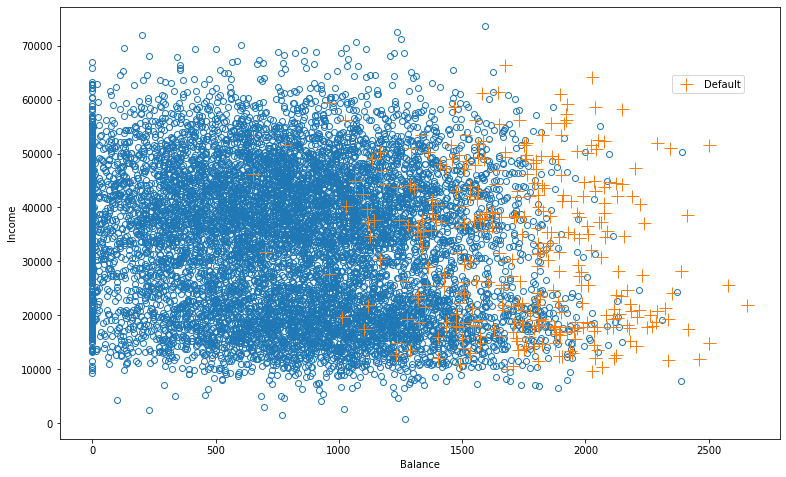

In [2]:
# Defaults Scatter Plot
default = pd.read_csv('../data/default.csv')
default['default'] = default['default'].apply(lambda x: True if x == 'Yes' else False )

yes_x = default[default['default'] == True]['balance']
no_x = default[default['default'] == False]['balance']
yes_y = default[default['default'] == True]['income']
no_y = default[default['default'] == False]['income']

fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0,0,1,1])

ax.set_xlabel('Balance')
ax.set_ylabel('Income')

ax.plot(no_x, no_y, 'o', markerfacecolor='None')
ax.plot(yes_x, yes_y, '+', label='Default', markersize=13)

ax.legend(loc=(0.85,0.8))
plt.show()

---

# Why Not Linear Regression

Suppose that we are trying to predict the medical condition of a patient in the emergency room on the basis of her symptoms. In this simplified example, there are three possible diagnoses: **stroke**, **drug overdose**, and **epileptic seizure**. We could consider encoding these values as a quantitative response variable, $Y$, as follows:

\begin{align*}
    Y = \begin{cases}
            1 & \text{if stroke;} \newline 2 & \text{if drug overdose;} \newline 3 & \text{if epileptic seizure.}
        \end{cases}
\end{align*}

Using this coding, least squares could be used to fit a linear regression model to predict $Y$ on the basis of a set of predictors $X_1 , \ldots , X_p$ . Unfortunately, this coding implies an ordering on the outcomes, putting drug overdose in between stroke and epileptic seizure, and insisting that the difference between stroke and drug overdose is the same as the difference between drug overdose and epileptic seizure.

**In practice there is no particular reason that this 1, 2, 3 coding needs to be the case.**
For instance, one could choose an equally reasonable coding,

\begin{align*}
    Y = \begin{cases}
            1 & \text{if epileptic seizure;} \newline 2 & \text{if stroke;} \newline 3 & \text{if drug overdose.}
        \end{cases}
\end{align*}

Each different coding would produce fundamentally different linear models that would ultimately lead to different sets of predictions on test observations.

If the response variable’s values did take on a natural ordering, such as
mild, moderate, and severe, and we felt the gap between mild and moderate
was similar to the gap between moderate and severe, then a 1, 2, 3 coding
would be reasonable. Unfortunately, in general there is no natural way to
convert a qualitative response variable with more than two levels into a
quantitative response that is ready for linear regression.

For a *binary* (two level) qualitative response, the situation is better. We could then potentially use the dummy variable approach to code the response as follows:

\begin{align*}
    Y = \begin{cases}
            1 & \text{if stroke;} \newline 2 & \text{if drug overdose.}
        \end{cases}
\end{align*}

We could then fit a linear regression to this binary response, and predict **drug overdose** if $\hat{Y} > 0.5$ and **stroke** otherwise. For a binary response with a 0/1 coding as above, regression by least squares does make sense; it can be shown that the $X \hat{\beta}$ obtained using linear regression is in fact an estimate of $\text{ Pr}(\text{ drug overdose }|X)$ in this special case. However, if we use linear regression, some of our estimates might be outside the $[0, 1]$ interval making them hard to interpret as probabilities.

Curiously, it turns out that the classifications that we get if we use linear regression to predict a binary
response will be the same as for the [Linear Discriminant Analysis](#Linear-Discriminant-Analysis) (LDA) procedure we discuss later.

However, the dummy variable approach cannot be easily extended to
accommodate qualitative responses with more than two levels. For these
reasons, it is preferable to use a classification method that is truly suited
for qualitative response values, such as the ones presented next.

---

# Logistic Regression

Consider again the *Default* data set, where the response **default** falls into one of two categories, **Yes** or **No**. Rather than modeling this response $Y$ directly, logistic regression models the *probability* that $Y$ belongs to a particular category.

For the Default data, logistic regression models the probability of default. For example, the probability of default given balance can be written as

\begin{align*}
    \text{Pr}( \text{default } =  \text{ Yes} | \text{balance}) 
\end{align*}

The values of $\text{Pr}( \text{default } =  \text{ Yes} | \text{balance})$, which we abbreviate $p(\text{balance})$, will range between $0$ and $1$. Then for any given value of **balance**, a prediction can be made for **default** using some threshold. For example, if a company wishes to be conservative in predicting individuals who are at risk for default, then they may choose to use a low threshold, such as $p(\text{balance}) > 0.1$.

## The Logistic Model

How should we model the relationship between $p(X) = \text { Pr}(Y = 1|X)$ and $X$? (For convenience we are using the generic $0/1$ coding for the response). In the previous section we talked of using a linear regression model to represent these probabilities:

\begin{equation}\label{4.1}
    p(X) = \beta_0 + \beta_1 X.
\end{equation}

Here we see the problem with this approach: for balances close to zero we predict a negative probability of default; if we were to predict for very large balances, we would get values bigger than 1. In fact, any time a straight line is fit to a binary response that is coded as $0$ or $1$, in principle we can always predict $p(X) < 0$ for some values of $X$ and $p(X) > 1$ for others (unless the range of $X$ is limited).

To avoid this problem, we must model $p(X)$ using a function that gives outputs between $0$ and $1$ for all values of $X$. Many functions meet this description. In logistic regression, we use the **logistic function**,

\begin{equation}\label{4.2}
    p(X) = \frac{e^{\beta_0 + \beta_1 X}}{ 1 + e^{\beta_0 + \beta_1 X}}.
\end{equation}

To fit the model (\ref{4.2}), we use a method called **maximum likelihood**, which we discuss in the next section.

![Logistic Function Curve](figures/4.2.png)

The logistic function will always produce an S-shaped curve of this form, and so regardless of the value of $X$, we will obtain a sensible prediction.

After a bit of manipulation of (\ref{4.2}), we find that

\begin{equation}\label{4.3}
    \frac{p(X)}{1 - p(X)} = e^{\beta_0 + \beta_1 X}.
\end{equation}

The quantity $p(X)/[1 − p(X)]$ is called the **odds**, and can take on any value between $0$ and $\infty$.
By taking the logarithm of both sides of (\ref{4.3}), we arrive at

\begin{equation}\label{4.4}
    \text{log} \left( \frac{p(X)}{1 - p(X)} \right) = \beta_0 + \beta_1 X.
\end{equation}

The left-hand side is called the **log-odds** or **logit**. We see that the logistic regression model (\ref{4.2}) has a logit that is linear in $X$. Recall from Chapter 3 that in a linear regression model, $\beta_1$ gives the average change in $Y$ associated with a one-unit increase in $X$. In contrast, in a logistic regression model, increasing $X$ by one unit changes the log odds by $\beta_1$ (\ref{4.4}), or equivalently it multiplies the odds by $e^{\beta_1}$ (\ref{4.3}). However, because the relationship between $p(X)$ and $X$ in (\ref{4.2}) is not a straight line, $\beta_1$ does *not* correspond to the change in $p(X)$ associated with a one-unit increase in $X$. The amount that $p(X)$ changes due to a one-unit change in $X$ will depend on the current value of $X$.

## Estimating the Regression Coefficients
As stated before, the preferred method of optimizing coefficients is **maximum likelihood**. The basic intuition behind using maximum likelihood to fit a logistic regression model is as follows: we seek estimates for $\beta_0$ and $\beta_1$ such that the predicted probability $\hat{p}(x_i)$ of default for each individual, using (\ref{4.2}), corresponds as closely as possible to the individual’s observed default status.

This intuition can be formalized using a mathematical equation called a **likelihood function**:

\begin{equation}\label{4.5}
    l(\beta_0, \beta_1) = \prod_{i: y_i = 1}p(x_i) \prod_{i': y_{i'} = 0} (1 - p(x_{i'})).
\end{equation}

The estimates $\hat{\beta}_0$ and $\hat{\beta}_1$ are chosen to *maximize* this likelihood function. Maximum likelihood is a very general approach that is used to fit many of the non-linear models that we examine throughout this book. The mathematical details of maximum likelihood are beyond the scope of this book. However, in general, logistic regression and other models can be easily fit using a statistical software package, and so we do not need to concern ourselves with the details of the maximum likelihood fitting procedure.

|               	| Coefficient 	| Std. error 	| Z-statistic 	| p-value  	|
|---------------	|-------------	|------------	|-------------	|----------	|
| **Intercept** 	| −10.6513    	| 0.3612     	| −29.5       	| <0.0001  	|
| **balance**   	| 0.0055      	| 0.0002     	| 24.9        	| <0.0001  	|

> **Table 4.1**. For the *Default* data, estimated coefficients of the logistic regression model that predicts the probability of default using balance. A one-unit increase in balance is associated with an increase in the log odds of default by
0.0055 units.

Many aspects of the logistic regression output shown in the table above are similar to the linear regression output of Chapter 3. For example, we can measure the accuracy of the coefficient estimates by computing their standard errors. The z-statistic in table above plays the same role as the t-statistic in the linear regression output. For
instance, the z-statistic associated with $\beta_1$ is equal to $\hat{\beta}_1 /\text{SE}(\hat{\beta}_1 )$, and so a large (absolute) value of the z-statistic indicates evidence against the null hypothesis $H_0: \beta_1 = 0$. This null hypothesis implies that $p(X) = \frac{e^{\beta_0}}{1+ e^{\beta_0}}$.  In other words, that the probability of **default** does not depend on **balance**.

## Making Predictions
Once the coefficients have been estimated, it is a simple matter to compute the probability of default for any given credit card balance. For example, using the coefficient estimates given in Table 4.1, we predict that the default probability for an individual with a balance of $\$1,000$ is

\begin{align*}
    \hat{p}(X) = \frac{e^{\hat{\beta}_0 + \hat{\beta}_1 X}}{1 + e^{\hat{\beta}_0 + \hat{\beta}_1 X}}
        = \frac{e^{-10.6513 + 0.0055 \times 1,000}}{1 + e^{-10.6513 + 0.0055 \times 1,000}} = 0.00576,
\end{align*}

which is below $1\%$. In contrast, the predicted probability of default for an individual with a balance of $\$2,000$ is much higher, and equals $0.586$ or $58.6 \%$.

One can use qualitative predictors with the logistic regression model using the dummy variable approach. As an example, the *Default* data set contains the qualitative variable **student**. Below is the resulting regression parameters.

|                   	| Coefficient 	| Std. error 	| Z-statistic 	| p-value  	|
|-------------------	|-------------	|------------	|-------------	|----------	|
| **Intercept** 	    | −3.5041    	| 0.0707     	| −49.55       	| <0.0001  	|
| **student[Yes]**   	| 0.4049      	| 0.1150     	| 3.52        	| 0.0004  	|

> **Table 4.2** For the Default data, estimated coefficients of the logistic regression model that predicts the probability of default using student status. Student status is encoded as a dummy variable, with a value of 1 for a student and a value of 0 for a non-student, and represented by the variable **student[Yes]** in the table.

The logistic regression model that results from predicting probability of default from student status can be seen in Table 4.2. The coefficient associated with the dummy variable is positive,and the associated p-value is statistically significant. This indicates that students tend to have higher default probabilities than non-students:

\begin{align*}
    \widehat{\text{Pr}}(\text{default} &= \text{Yes} | \text{student}=\text{Yes}) = \frac{e^{-3.5041 + 0.4049 \times 1}}{1 + e^{-3.5041 + 0.4049 \times 1}} = 0.0431, \newline
    \widehat{\text{Pr}}(\text{default} &= \text{Yes} | \text{student}=\text{No}) = \frac{e^{-3.5041 + 0.4049 \times 0}}{1 + e^{-3.5041 + 0.4049 \times 0}} = 0.0292
\end{align*}

## Multiple Logistic Regression
We now consider the problem of predicting a binary response using multiple predictors. By analogy with the extension from simple to multiple linear regression in Chapter 3, we can generalize (\ref{4.4}) as follows:

\begin{equation}\label{4.6}
    \text{log} \left( \frac{p(X)}{1 - p(X)} \right) = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p
\end{equation}

where $X = (X_1, \ldots , X_p)$ are $p$ predictors. Equation \ref{4.6} can be rewritten as

\begin{equation}\label{4.7}
    p(X) = \frac{e^{\beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p}}{1 + e^{\beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p}}
\end{equation}

Just as before, we use the maximum likelihood method to estimate $\beta_0, \beta_1, \ldots , \beta_p$. The results are shown below.

|                   	| Coefficient 	| Std. error 	| Z-statistic 	| p-value  	|
|-------------------	|-------------	|------------	|-------------	|----------	|
| **Intercept** 	    | −10.8690    	| 0.4923     	| -22.08       	| <0.0001  	|
| **balance**   	    | 0.0057    	| 0.0002     	| 24.74       	| <0.0001  	|
| **income**    	    | 0.0030    	| 0.0082     	| 0.37       	| 0.7115  	|
| **student[Yes]**   	| -0.6468      	| 0.2362     	| -2.74        	| 0.0062  	|

> **TABLE 4.3**. For the *Default* data, estimated coefficients of the logistic regression model that predicts the probability of default using **balance**, **income**, and **student** status. Student status is encoded as a dummy variable student[Yes], with a value of 1 for a student and a value of 0 for a non-student. In fitting this model, income was measured in thousands of dollars.

Table 4.3 shows the coefficient estimates for a logistic regression model that uses balance, income (in thousands of dollars), and student status to predict probability of default. There is a surprising result here. How is it possible for student status to be associated with an *increase* in probability of default in Table 4.2 and a *decrease* in probability of default in Table 4.3?

The negative coefficient for student in the multiple logistic regression indicates that for a *fixed value of* **balance** and **income**, **a student is less likely to default than a non-student**. But when the default rates for students and non-students are averaged over all values of balance and income (as in the single logistic regression model), **the overall student default rate is higher than the non-student default rate.**

The explanation here is that the variables **student** and **balance** are correlated. Students tend to hold higher levels of debt, which is in turn associated with higher probability of default. However, an individual student with a given credit card balance will tend to have a lower probability of default than a non-student with the same credit card balance.

This simple example illustrates the dangers and subtleties associated with performing regressions involving only a single predictor when other predictors may also be relevant. As in the linear regression setting, the results obtained using one predictor may be quite different from those obtained using multiple predictors, especially when there is correlation among the predictors. In general, this phenomenon is known as **confounding**.

## Logistic Regression for $>2$ Response Classes
The two-class logistic regression models discussed in the previous sections have multiple-class extensions, but in practice they tend not to be used all that often. One of the reasons is that the method we discuss in the next section, **discriminant analysis**, is popular for multiple-class classification. So we do not go into the details of multiple-class logistic regression here, but simply note that such an approach is possible, and that software for it is available.

---

# Linear Discriminant Analysis
 We now consider an alternative and less direct approach to estimating these probabilities. We model the distribution of the predictors $X$ separately in each of the response classes (i.e. given $Y$), and then use Bayes’ theorem to flip these around into estimates for $\text{Pr}(Y = k|X = x)$.
 
Why do we need another method, when we have logistic regression? There are several reasons:

- When the classes are well-separated, the parameter estimates for the logistic regression model are surprisingly unstable. Linear discriminant analysis does not suffer from this problem.

- If $n$ is small and the distribution of the predictors $X$ is approximately normal in each of the classes, the linear discriminant model is again more stable than the logistic regression model.

- Linear discriminant analysis is popular when we have more than two response classes.

## Using Bayes’ Theorem for Classification
Suppose that we wish to classify an observation into one of $K$ classes, where $K \le 2$. Let $\pi_k$ represent the overall or **prior** probability that a randomly chosen observation comes from the $k$th class. Let 
$f_k(x) \equiv \text{Pr}(X = x|Y = k)$ denote the density function of $X$ for an observation that comes from the $k$th class. Then Bayes’ theorem states that

\begin{equation}\label{4.10}
    \text{Pr}(Y = k|X = x) = \frac{\pi_k f_k(x)}{\sum_{l=1}^K \pi_l f_l(x)}
\end{equation}

In accordance with our earlier notation, we will use the abbreviation $p_k(X) = \text{Pr}(Y = k|X)$. We refer to $p_k(x)$ as the **posterior** probability that an observation $X = x$ belongs to the $k$th class. The Bayes classifier, which classifies an observation to the class for which $p_k(X)$ is largest, has the lowest possible error rate out of all classifiers.

## Linear Discriminant Analysis for $p = 1$
We would like to obtain an estimate for $f_k(x)$ that we can plug into (\ref{4.10}) in order to estimate $p_k(x)$. In order to estimate $f_k(x)$, we will first make some assumptions about its form.

Suppose we assume that $f_k (x)$ is normal or **Gaussian**. In the one-dimensional setting, the normal density takes the form

\begin{equation}\label{4.11}
    f_k(x) = \frac{1}{\sqrt{2 \pi } \sigma_k} \text{exp} \left( - \frac{1}{2 \sigma_{k}^{2}}(x - \mu_k)^2 \right)
\end{equation}

where $\mu_k$ and $\sigma_k^2$ are the mean and variance parameters for the $k$th class. For now, let us further assume that $σ_1^2 = \ldots = σ_K^2$: that is, there is a shared variance term across all $K$ classes, which for simplicity we can denote by $σ^2$. Plugging the one-dimensional Gaussian (\ref{4.11}) into Bayes' (\ref{4.10}), we find that

\begin{equation}\label{4.12}
    p_k(x) = \frac{\pi_k \frac{1}{\sqrt{2 \pi} \sigma} \text{exp}(- \frac{1}{2 \sigma^2} (x - \mu_k)^2 )}{\sum_{l=1}^K \pi_l \frac{1}{\sqrt{2 \pi} \sigma} \text{exp}(- \frac{1}{2 \sigma^2} (x - \mu_l)^2 )} 
\end{equation}

Taking the log of (\ref{4.12}) and rearranging the terms, it is not hard to show that this is equivalent to assigning the observation to the class for which the below equation is largest.

\begin{equation}\label{4.13}
    \delta_k(x) = x \cdot \frac{\mu_k}{\sigma^2} - \frac{\mu_k^2}{2 \sigma^2} + \text{log}(\pi_k)
\end{equation}

In practice, even if we are quite certain of our assumption that $X$ is drawn from a Gaussian distribution within each class, we still have to estimate the parameters $\mu_1, \ldots ,\mu_K$, $\pi_1, \ldots , \pi_K$, and $\sigma^2$. The **linear discriminant analysis** (LDA) method approximates the Bayes classifier by plugging estimates for $\pi_k , \mu_k$ , and $\sigma^2$ into (\ref{4.13}). In particular, the following estimates are used:

\begin{equation}\label{4.15}
    \hat{\mu}_k = \frac{1}{n_k} \sum_{i:y_i = k} x_i \newline
    \hat{\sigma}^2 = \frac{1}{n - K} \sum_{k=1}^K \sum_{i:y_i = k} (x_i - \hat{\mu}_k)^2
\end{equation}

where $n$ is the total number of training observations, and $n_k$ is the number of training observations in the $k$th class. The estimate for $\mu_k$ is simply the average of all the training observations from the $k$th class, while $\hat{\sigma}^2$ can be seen as a weighted average of the sample variances for each of the $K$ classes. Sometimes we have knowledge of the class membership probabilities $\pi_1 , \ldots , \pi_K$, which can be used directly. In the absence of any additional information, LDA estimates $\pi_k$ using the proportion of the training observations that belong to the kth class. In other words,

\begin{equation}\label{4.16}
    \hat{\pi}_k = n_k / n.
\end{equation}

The LDA classifier plugs the estimates given in (\ref{4.15}) and (\ref{4.16}) into (\ref{4.13}), and assigns an observation $X = x$ to the class for which the following is largest.

\begin{equation}\label{4.17}
    \hat{\delta}_k = x \cdot \frac{ \hat{\mu}_k }{ \hat{\sigma}^2 } - \frac{ \hat{\mu}^2_k }{2 \hat{\sigma}^2} + \text{log}(\hat{\pi}_k)
\end{equation}

The word *linear* in the classifier’s name stems from the fact that the discriminant functions $\hat{\delta}_k(x)$ in (\ref{4.17}) are linear functions of $x$.

To reiterate, the LDA classifier results from assuming that the observations within each class come from a normal distribution with a class-specific mean vector and a common variance $\sigma^2$, and plugging estimates for these
parameters into the Bayes classifier. 

## Linear Discriminant Analysis for $p > 1$
We now extend the LDA classifier to the case of multiple predictors. To do this, we will assume that $X = (X_1, X_2 , \ldots, X_p )$ is drawn from a multivariate Gaussian (or multivariate normal) distribution, with a class-specific mean vector and a common covariance matrix.

Refer to the text for the multivariate Gaussian density function the resulting Bayes classifier, and Bayes decision boundary, which are vector/matrix versions of their single dimensional counterparts.

Sensitivity and specificity characterize the performance of a classifier or screening test. In this case the **sensitivity** is the percentage of true defaulters that are identified. The **specificity** is the percentage of non-defaulters that are correctly identified. LDA is trying to approximate the Bayes classifier, which has the low-
est *total* error rate out of all classifiers. The Bayes classifier will yield the smallest possible total number
of misclassified observations, irrespective of which class the errors come from.

However, it is possible to modify LDA in order to develop a classifier that better meets the performance requirements of the situation. We can show this using the *Default* credit card data.

The Bayes classifier works by assigning an observation to the class for which the posterior probability $p_k (X)$ is greatest. In the two-class case, this amounts to assigning an observation to the *default* class if

\begin{equation}\label{4.21}
    \text{Pr}(\text{default} = \text{Yes} | X = x) > 0.5
\end{equation}

Thus, the Bayes classifier, and by extension LDA, uses a threshold of $50 \%$ for the posterior probability of default in order to assign an observation to the default class. However, if we are concerned about incorrectly predicting the default status for individuals who default, then we can consider lowering this threshold. For example,

\begin{equation}\label{4.22}
    \text{Pr}(\text{default} = \text{Yes} | X = x) > 0.2
\end{equation}

When a threshold of $0.5$ is used, the error rate among the individuals who default is quite high. As the threshold is reduced, the error rate among individuals who default decreases steadily, but the error rate among the individuals who do not default increases. How can we decide which threshold value is best? Such a decision must be based on *domain knowledge*, such as detailed information about the costs associated with default.

The **ROC curve** is a popular graphic for simultaneously displaying the two types of errors for all possible thresholds. It is an acronym for *receiver operating characteristics*. The overall performance of a classifier, summarized over all possible thresholds, is given by the **area under the (ROC) curve** (AUC).

![Default ROC curve](figures/4.8.png)
> **Figure 4.8.** The true positive rate is the sensitivity. The false positive rate is 1-specificity. The dotted line represents the “no information” classifier; this is what we would expect if student status and credit card balance are not associated with probability of default.

An ideal ROC curve will hug the top left corner, so the larger the AUC the better the classifier. For this data the AUC is $0.95$, which is close to the maximum of one so would be considered very good. We expect a classifier that performs no better than chance to have an AUC of $0.5$.

As we have seen above, varying the classifier threshold changes its true positive and false positive rate. These are also called the **sensitivity** and **one minus the specificity** of our classifier.

## Quadratic Discriminant Analysis
Like LDA, the **Quadratic Discriminant Analysis** (QDA) classifier results from assuming that the observations from each class are drawn from a Gaussian distribution, and plugging estimates for the parameters into Bayes’ theorem in order to perform prediction. However, unlike LDA, QDA assumes that each class $k$ has its own covariance matrix $\Sigma_k$.

This results in a different result from the Bayes classifier and decision boundary. LDA is a much less flexible classifier than QDA, and so has substantially lower variance. This can potentially lead to improved prediction performance. But there is a trade-off: if LDA’s assumption that the K classes share a common covariance matrix is badly off, then LDA can suffer from high bias. Roughly speaking, LDA tends to be a better bet than QDA if there are relatively few training observations and so reducing variance is crucial. In contrast, QDA is recommended if the training set is very large, so that the variance of the classifier is not a major concern, or if the assumption of a common covariance matrix for the K classes is clearly untenable.

![LDA vs QDA](figures/4.9.png)
> **Figure 4.9.** *Left:* The Bayes (purple dashed), LDA (black dotted), and QDA (green solid) decision boundaries for a two-class problem with $\Sigma_1 = \Sigma_2$. The shading indicates the QDA decision rule. Since the Bayes decision boundary is linear, it is more accurately approximated by LDA than by QDA.  
*Right:* Details are as given in the left-hand panel, except that $\Sigma_1 \neq \Sigma_2$. Since the Bayes decision boundary is non-linear, it is more accurately approximated by QDA than by LDA.

---

# A Comparison of Classification Methods
Though their motivations differ, the logistic regression and LDA methods are closely connected. Consider the two-class setting with $p = 1$ predictor, and let $p_1 (x)$ and $p_2(x) = 1−p_1(x)$ be the probabilities that the observation $X = x$ belongs to class 1 and class 2, respectively. In the LDA framework, we can see from (\ref{4.12}) to (\ref{4.13}) (and a bit of simple algebra) that the log odds is given by

\begin{equation}\label{4.24}
    \text{log} \left( \frac{p_1(x)}{1 - p_1(x)} \right) = \text{log} \left( \frac{p_1(x)}{p_2(x)} \right) = c_0 + c_1 x
\end{equation}

where $c_0$ and $c_1$ are functions of $\mu_1$, $\mu_2$, and $\sigma^2$. From (\ref{4.4}), we know that in logistic regression,

\begin{equation}\label{4.25}
    \text{log} \left( \frac{p_1}{1 - p_1} \right) = \beta_0 + \beta_1x
\end{equation}

Both (\ref{4.24}) and (\ref{4.25}) are linear functions of $x$. Hence, both logistic regression and LDA produce linear decision boundaries. The only difference between the two approaches lies in the fact that $\beta_0$ and $\beta_1$ are estimated using maximum likelihood, whereas $c_0$ and $c_1$ are computed using the estimated mean and variance from a normal distribution. This same connection between LDA and logistic regression also holds for multidimensional data with $p > 1$.

Since logistic regression and LDA differ only in their fitting procedures, one might expect the two approaches to give similar results. This is often, but not always, the case. LDA assumes that the observations are drawn from a Gaussian distribution with a common covariance matrix in each class, *and so can provide some improvements over logistic regression when this assumption approximately holds*. Conversely, *logistic regression can outperform LDA if these Gaussian assumptions are not met*.

KNN is a completely non-parametric approach: no assumptions are made about the shape of the decision boundary. Therefore, we can expect this approach to dominate LDA and logistic regression when the decision boundary is highly non-linear. On the other hand, KNN does not tell us which predictors are important; we don’t get a table of
coefficients.

Finally, QDA serves as a compromise between the non-parametric KNN method and the linear LDA and logistic regression approaches. Since QDA assumes a quadratic decision boundary, it can accurately model a wider range of problems than can the linear methods. Though not as flexible as KNN, QDA can perform better in the presence of a limited number of training observations because it does make some assumptions about the form of the decision boundary.

When the true decision boundaries are linear, then the LDA and logistic regression approaches will tend to perform well. When the boundaries are moderately non-linear, QDA may give better results. Finally, for much more complicated decision boundaries, a non-parametric approach such as KNN can be superior. But the level of smoothness for a non-parametric approach must be chosen carefully.

---
# End Chapter